# Credit Card Approval Prediction #

### Context ###

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.
 
Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.
 
At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.

### Content & Explanation ###

#### application_record.csv		 ####

ID - Client number	
CODE_GENDER - Gender	
FLAG_OWN_CAR - Is there a car	
FLAG_OWN_REALTY - Is there a property	
CNT_CHILDREN - Number of children	
AMT_INCOME_TOTAL - Annual income	
NAME_INCOME_TYPE - Income category	
NAME_EDUCATION_TYPE - Education level	
NAME_FAMILY_STATUS - Marital status	
NAME_HOUSING_TYPE - Way of living	
DAYS_BIRTH	Birthday - Count backwards from current day (0), -1 means yesterday
DAYS_EMPLOYED - Start date of employment	Count backwards from current day(0). If positive, it means the person currently unemployed.
FLAG_MOBIL - Is there a mobile phone	
FLAG_WORK_PHONE - Is there a work phone	
FLAG_PHONE - Is there a phone	
FLAG_EMAIL - Is there an email	
OCCUPATION_TYPE - Occupation	
CNT_FAM_MEMBERS - Family size	

#### credit_record.csv		 ####

ID - Client number	
MONTHS_BALANCE - Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
STATUS - Status	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

## 1. Importing Data and EDA ##

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
import sys
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

OSError: [WinError 193] %1 не является приложением Win32

In [2]:
application = pd.read_csv('application_record.csv')
credit = pd.read_csv('credit_record.csv')

In [3]:
application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


Проверим датасеты на наличие дубликатов в столбце ID (уникальный номер клиента):

In [6]:
credit[credit.ID.duplicated()]

,ID,MONTHS_BALANCE,STATUS
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
5,5001712,-1,C
6,5001712,-2,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


Мы видим, что имеются дубликаты. Это связано с тем, что в датасете credit собраны данные за разные месяцы выгрузки. Считаю возможным удалить дубликаты:

In [7]:
credit = credit.drop_duplicates(subset=['ID'])

In [8]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45985 entries, 0 to 1048545
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              45985 non-null  int64 
 1   MONTHS_BALANCE  45985 non-null  int64 
 2   STATUS          45985 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [9]:
application = application.drop_duplicates(subset=['ID'])

In [10]:
application.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438510 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438510 non-null  int64  
 1   CODE_GENDER          438510 non-null  object 
 2   FLAG_OWN_CAR         438510 non-null  object 
 3   FLAG_OWN_REALTY      438510 non-null  object 
 4   CNT_CHILDREN         438510 non-null  int64  
 5   AMT_INCOME_TOTAL     438510 non-null  float64
 6   NAME_INCOME_TYPE     438510 non-null  object 
 7   NAME_EDUCATION_TYPE  438510 non-null  object 
 8   NAME_FAMILY_STATUS   438510 non-null  object 
 9   NAME_HOUSING_TYPE    438510 non-null  object 
 10  DAYS_BIRTH           438510 non-null  int64  
 11  DAYS_EMPLOYED        438510 non-null  int64  
 12  FLAG_MOBIL           438510 non-null  int64  
 13  FLAG_WORK_PHONE      438510 non-null  int64  
 14  FLAG_PHONE           438510 non-null  int64  
 15  FLAG_EMAIL       

In [11]:
len(credit.ID.unique())

45985

In [12]:
len(application.ID.unique())

438510

Объединяем датасеты credit и application, используя метод merge. В столбце OCCUPATION_TYPE мы видим пропуски, заменяю их на значения 'unknown', так как удаление этих данных не целесообразно.

In [13]:
df = credit.merge(application, how = 'inner', left_on='ID', right_on='ID').fillna('unknown')

In [14]:
df.head()

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,unknown,2.0
1,5008805,0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,unknown,2.0
2,5008806,0,C,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,0,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,-22,X,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   MONTHS_BALANCE       36457 non-null  int64  
 2   STATUS               36457 non-null  object 
 3   CODE_GENDER          36457 non-null  object 
 4   FLAG_OWN_CAR         36457 non-null  object 
 5   FLAG_OWN_REALTY      36457 non-null  object 
 6   CNT_CHILDREN         36457 non-null  int64  
 7   AMT_INCOME_TOTAL     36457 non-null  float64
 8   NAME_INCOME_TYPE     36457 non-null  object 
 9   NAME_EDUCATION_TYPE  36457 non-null  object 
 10  NAME_FAMILY_STATUS   36457 non-null  object 
 11  NAME_HOUSING_TYPE    36457 non-null  object 
 12  DAYS_BIRTH           36457 non-null  int64  
 13  DAYS_EMPLOYED        36457 non-null  int64  
 14  FLAG_MOBIL           36457 non-null  int64  
 15  FLAG_WORK_PHONE      36457 non-null 

Теперь пропусков в датасете нет. Так же для удобства дальнейшей работы переименуем столбцы:

In [16]:
df.rename(columns={"CODE_GENDER":"Gender","FLAG_OWN_CAR":"Car","FLAG_OWN_REALTY":"Realty",
                     "CNT_CHILDREN":"Children_Count","AMT_INCOME_TOTAL":"Income","NAME_EDUCATION_TYPE":"Education",
                     "NAME_FAMILY_STATUS":"Family_Status","NAME_HOUSING_TYPE":"Housing_Type","DAYS_BIRTH":"Birthday",
                     "DAYS_EMPLOYED":"Employment_Date","FLAG_MOBIL":"Mobile","FLAG_WORK_PHONE":"Work_Phone",
                     "FLAG_PHONE":"Phone","FLAG_EMAIL":"Email","CNT_FAM_MEMBERS":"Family_Member_Count",
                    "NAME_INCOME_TYPE":"Income_Type"},inplace=True)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   MONTHS_BALANCE       36457 non-null  int64  
 2   STATUS               36457 non-null  object 
 3   Gender               36457 non-null  object 
 4   Car                  36457 non-null  object 
 5   Realty               36457 non-null  object 
 6   Children_Count       36457 non-null  int64  
 7   Income               36457 non-null  float64
 8   Income_Type          36457 non-null  object 
 9   Education            36457 non-null  object 
 10  Family_Status        36457 non-null  object 
 11  Housing_Type         36457 non-null  object 
 12  Birthday             36457 non-null  int64  
 13  Employment_Date      36457 non-null  int64  
 14  Mobile               36457 non-null  int64  
 15  Work_Phone           36457 non-null 

Преобразовываем даты:

In [18]:
df['Birthday'] = df['Birthday']/(-1*365)
df['Employment_Date'] = df['Employment_Date']/(-1*365)

df['Birthday'] = df.Birthday.astype('int64')
df['Income'] = df.Income.astype('int64')
df['Family_Member_Count'] = df.Family_Member_Count.astype('int64')
df.head()

,ID,MONTHS_BALANCE,STATUS,Gender,Car,Realty,Children_Count,Income,Income_Type,Education,Family_Status,Housing_Type,Birthday,Employment_Date,Mobile,Work_Phone,Phone,Email,OCCUPATION_TYPE,Family_Member_Count
0,5008804,0,C,M,Y,Y,0,427500,Working,Higher education,Civil marriage,Rented apartment,32,12.443836,1,1,0,0,unknown,2
1,5008805,0,C,M,Y,Y,0,427500,Working,Higher education,Civil marriage,Rented apartment,32,12.443836,1,1,0,0,unknown,2
2,5008806,0,C,M,Y,Y,0,112500,Working,Secondary / secondary special,Married,House / apartment,58,3.106849,1,0,0,0,Security staff,2
3,5008808,0,0,F,N,Y,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8.358904,1,0,1,1,Sales staff,1
4,5008809,-22,X,F,N,Y,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8.358904,1,0,1,1,Sales staff,1


In [20]:
df.describe()

,ID,MONTHS_BALANCE,Children_Count,Income,Birthday,Employment_Date,Mobile,Work_Phone,Phone,Email,Family_Member_Count
count,3.645700e+04,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,-5.831802,0.430315,1.866857e+05,43.260334,-162.364207,1.0,0.225526,0.294813,0.089722,2.198453
std,4.187524e+04,11.326494,0.742367,1.017892e+05,11.510414,377.126945,0.0,0.417934,0.455965,0.285787,0.911686
min,5.008804e+06,-60.000000,0.000000,2.700000e+04,20.000000,-1000.665753,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.042028e+06,-6.000000,0.000000,1.215000e+05,34.000000,1.117808,1.0,0.000000,0.000000,0.000000,2.000000
50%,5.074614e+06,0.000000,0.000000,1.575000e+05,42.000000,4.252055,1.0,0.000000,0.000000,0.000000,2.000000
75%,5.115396e+06,0.000000,1.000000,2.250000e+05,53.000000,8.638356,1.0,0.000000,1.000000,0.000000,3.000000
max,5.150487e+06,0.000000,19.000000,1.575000e+06,68.000000,43.049315,1.0,1.000000,1.000000,1.000000,20.000000


In [183]:
Children_Count	, Birthday,	Family_Member_Count

NameError: name 'Children_Count' is not defined

## Visualization ##

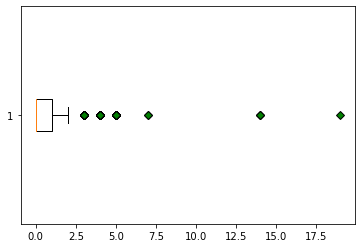

In [21]:
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(df['Children_Count'], vert=0, flierprops=green_diamond)
plt.show()

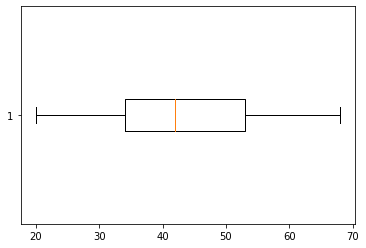

In [22]:
plt.boxplot(df['Birthday'], vert=0, flierprops=green_diamond)
plt.show()

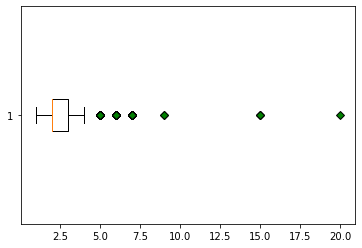

In [23]:
plt.boxplot(df['Family_Member_Count'], vert=0, flierprops=green_diamond)
plt.show()

Удаляем выбросы (число детей более 12) и размер семьи более 15 человек:

In [24]:
df.drop(df[df.Children_Count > 12].index, inplace=True)


In [25]:
df.drop(df[df.Family_Member_Count > 15].index, inplace=True)

In [27]:
len(df.Mobile.unique())

1

Так как в столбце Mobile только 1 значение, эти данные не имеют значения для построения модели.

In [39]:
df.drop('Mobile',axis=1,inplace=True)
df.drop('Email',axis=1,inplace=True)
df.drop('Work_Phone',axis=1,inplace=True)
df.drop('Phone',axis=1,inplace=True)

#### Label encoding ####

In [41]:
df_enc = ['STATUS', 'Gender','Car', 'Realty','Income_Type','Education','Family_Status','Housing_Type','OCCUPATION_TYPE']

for col in df_enc:
    print(df[col].unique())
    
df.info()

['C' '0' 'X' '1' '3' '5' '2' '4']
['M' 'F']
['Y' 'N']
['Y' 'N']
['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
['unknown' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Low-skill Laborers' 'Medicine staff' 'Secretaries'
 'Waiters/barmen staff' 'HR staff' 'Realty agents' 'IT staff']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36453 entries, 0 to 36456
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36453 non-null  int64  
 1   M

In [42]:
le = preprocessing.LabelEncoder()

for col in df_enc:
    df[col] = le.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36453 entries, 0 to 36456
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36453 non-null  int64  
 1   MONTHS_BALANCE       36453 non-null  int64  
 2   STATUS               36453 non-null  int32  
 3   Gender               36453 non-null  int32  
 4   Car                  36453 non-null  int32  
 5   Realty               36453 non-null  int32  
 6   Children_Count       36453 non-null  int64  
 7   Income               36453 non-null  int64  
 8   Income_Type          36453 non-null  int32  
 9   Education            36453 non-null  int32  
 10  Family_Status        36453 non-null  int32  
 11  Housing_Type         36453 non-null  int32  
 12  Birthday             36453 non-null  int64  
 13  Employment_Date      36453 non-null  float64
 14  OCCUPATION_TYPE      36453 non-null  int32  
 15  Family_Member_Count  36453 non-null 

In [196]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,36453.0,5.078228e+06,41877.017974,5.008804e+06,5.042027e+06,5.074615e+06,5.115397e+06,5.150487e+06
MONTHS_BALANCE,36453.0,-5.832442e+00,11.326950,-6.000000e+01,-6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
STATUS,36453.0,4.831290e+00,2.729152,0.000000e+00,6.000000e+00,6.000000e+00,7.000000e+00,7.000000e+00
Gender,36453.0,3.298494e-01,0.470165,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Car,36453.0,3.796670e-01,0.485311,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Realty,36453.0,6.721532e-01,0.469435,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Children_Count,36453.0,4.286890e-01,0.725639,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.000000e+00
Income,36453.0,1.866846e+05,101793.476413,2.700000e+04,1.215000e+05,1.575000e+05,2.250000e+05,1.575000e+06
Income_Type,36453.0,2.398019e+00,1.734046,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
Education,36453.0,3.097084e+00,1.341332,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


<AxesSubplot:>

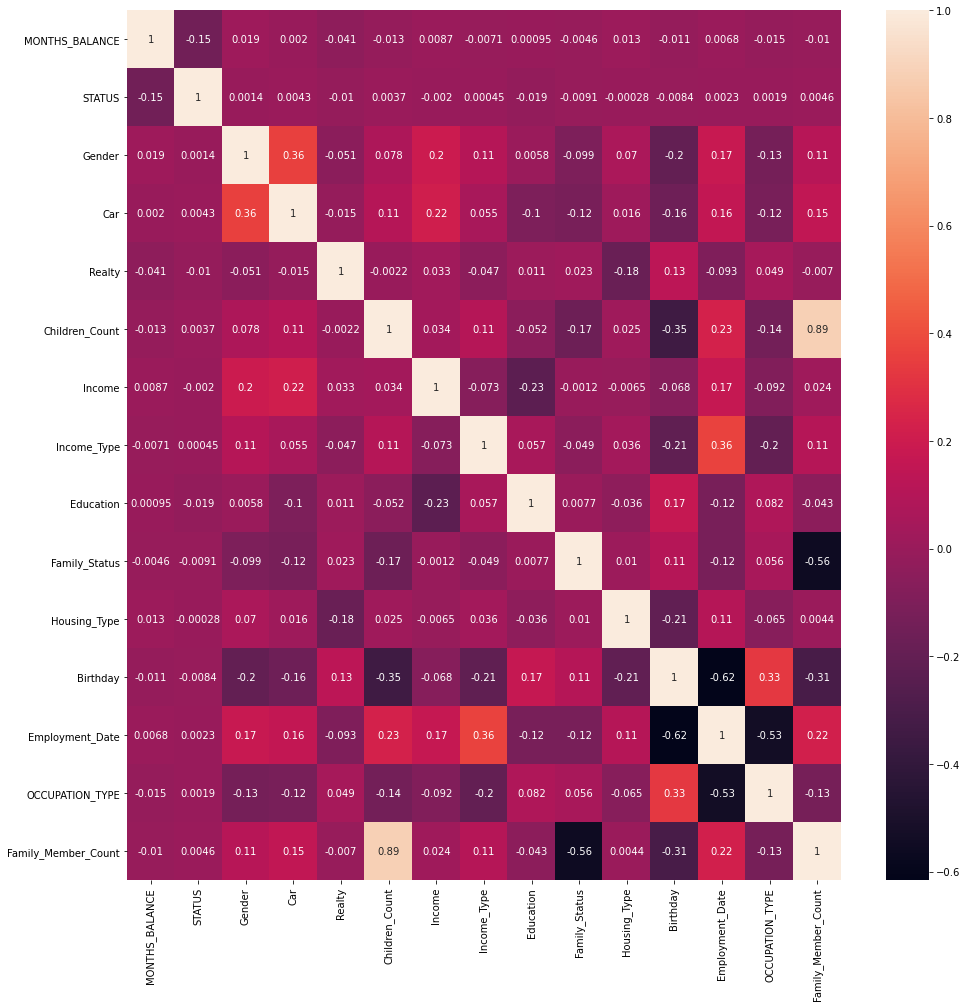

In [44]:
corr = df.drop(['ID'],axis=1).corr()
plt.figure(figsize = (16,16))
sns.heatmap(corr, annot=True)

### train_test_split ###

In [54]:
X = df.drop(['ID','STATUS'],axis = 1)
y = df['STATUS']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=100)

In [57]:
print(X_train.shape)

(25517, 14)


## Machine learning ##

In [ ]:
RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state = 0)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print("Accuracy = " , accuracy_score(y_val, y_predict))
print("F1 = " , f1_score(y_val, y_predict))

In [ ]:
XGBClassifier

In [ ]:
model =  XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print("Accuracy = " , accuracy_score(y_val, y_predict))
print("F1 = " , f1_score(y_val, y_predict))

In [ ]:
SVMClassifier

In [ ]:
model = SVC(C=1,gamma = 0.001)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print("Accuracy = " , accuracy_score(y_val, y_predict))
print("F1 = " , f1_score(y_val, y_predict))

In [ ]:
MLPClassifier

In [ ]:
model = MLPClassifier(verbose = 0 , max_iter = 46 , random_state = 0)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print("Accuracy = " , accuracy_score(y_val, y_predict))
print("F1 = " , f1_score(y_val, y_predict))